#### Script to establish a set of model vertical levels

James Ruppert\
jruppert@ou.edu\
12/22/23

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import getvar, disable_xarray#, latlon_coords
import sys

In [7]:
wrf_file = "WRF/run/wrfinput_d01"#wrfout_d01_2021-08-27_00:00:00"
ncfile = Dataset(wrf_file)
disable_xarray()

# tmpk = getvar(ncfile, "tk") # K
# pres = getvar(ncfile, "pressure")*1e2 # hPa --> Pa
# qv = getvar(ncfile, "QVAPOR") # kg/kg
hght = getvar(ncfile, "zstag", units='m')[:,0,0] # m
# lats, lons = latlon_coords(tmpk)

ncfile.close()

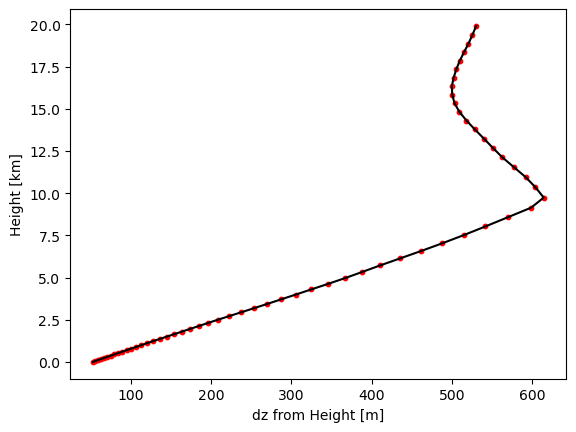

In [8]:
# Plot WRF dz vs. height
nz = hght.size-1
dz = np.zeros(nz)
for iz in range(nz):
    dz[iz] = hght[iz+1]-hght[iz]
# plt.plot(dz,hght[:nz]*1e-3)
ztop = np.min(np.where(hght > 20e3))
plt.plot(dz[:ztop],hght[:ztop]*1e-3, 'k')
plt.xlabel("dz from Height [m]")
plt.ylabel("Height [km]")
plt.scatter(dz[:ztop],hght[:ztop]*1e-3, s=10, c='red')

In [9]:
# WRF Stretched vertical levels subroutine

def get_dz(nlev, ptop, dzmax, dzbot, dzstretch_s, dzstretch_u):

    verbose=False
    verbose=True

    r_d=287
    g=9.81

    print("nlev = ", nlev)
    # print("ptop = ", ptop)
    # print("dzmax = ", dzmax)
    # print("dzbot = ", dzbot)
    print("dzstretch_s = ", dzstretch_s)
    print("dzstretch_u = ", dzstretch_u)
    print()

    # real, dimension(nlev) :: zup, pup
    zup = np.zeros(nlev)
    pup = np.zeros(nlev)
    eta = np.zeros(nlev+1)
    dz_sav = np.zeros(nlev)
    # real :: tt, a
    # real :: ztop, dz, dztest, zscale
    # integer :: isave, i

    tt=290. # isothermal temperature used for z/log p relation - tt=290 fits dzbot
    ztop=r_d*tt/g*np.log(1.e5/ptop)
    if verbose:
        print(ztop,nlev)
    zscale=r_d*tt/g
    dz=dzbot
    dz_sav[0]=dz
    zup[1]=dz
    pup[1]=1.e5*np.exp(-g*zup[1]/r_d/tt)
    eta[0]=1.0
    eta[1]=(pup[1]-ptop)/(1.e5-ptop)
    if verbose:
        print(1,dz,zup[1],eta[1])
    isave=1
    for i in range(1,nlev-1):
        a=dzstretch_u+(dzstretch_s-dzstretch_u)*np.max([(dzmax*0.5-dz)/(dzmax*0.5), 0.])
        dz=a*dz
        # print(dz)
        dztest=(ztop-zup[isave])/(nlev-isave)
        if(dztest < dz):
            continue
        isave=i+1
        zup[i+1]=zup[i]+dz
        pup[i+1]=1.e5*np.exp(-g*zup[i+1]/r_d/tt)
        eta[i+1]=(pup[i+1]-ptop)/(1.e5-ptop)
        dz_sav[i]=dz
        if verbose:
            print(i+1,dz,zup[i+1],eta[i+1],a)
        if i == nlev-1:
            print("ERROR #1 !!")
            sys.exit()
            # CALL wrf_debug ( 0, 'You need one of four things:' )
            # CALL wrf_debug ( 0, '1) More eta levels: e_vert' )
            # CALL wrf_debug ( 0, '2) A lower p_top: p_top_requested')
            # CALL wrf_debug ( 0, '3) Increase the lowest eta thickness: dzbot')
            # CALL wrf_debug ( 0, '4) Increase the stretching factor: dzstretch_s or dzstretch_u')
            # CALL wrf_debug ( 0, 'All are namelist options')
            # CALL wrf_error_fatal ( 'not enough eta levels to reach p_top')
    if verbose:
        print()
        print(ztop,zup[isave],nlev,isave)
        print()
    dz=(ztop-zup[isave])/(nlev-isave)
    dz_sav[isave-1]=dz
    if dz > 1.5*dzmax:       # isothermal temp 1.5 times stratosphere temp
        print("ERROR #2 !!")
        sys.exit()
    #         # CALL wrf_debug ( 0, 'Warning: Upper levels may be too thick' )
    #         # CALL wrf_debug ( 0, 'You need one of five things:' )
    #         # CALL wrf_debug ( 0, '1) More eta levels: e_vert' )
    #         # CALL wrf_debug ( 0, '2) A lower p_top: p_top_requested')
    #         # CALL wrf_debug ( 0, '3) Increase the lowest eta thickness: dzbot')
    #         # CALL wrf_debug ( 0, '4) Increase the stretching factor: dzstretch_s or dzstretch_u')
    #         # CALL wrf_debug ( 0, '5) Increase the maximum allowed thickness: max_dz')
    #         # CALL wrf_debug ( 0, 'All are namelist options')
    #         # CALL wrf_error_fatal ( 'Upper levels may be too thick')
    for i in range(isave,nlev-1):
        zup[i+1]=zup[i]+dz
        pup[i+1]=1.e5*np.exp(-g*zup[i+1]/r_d/tt)
        eta[i+1]=(pup[i+1]-ptop)/(1.e5-ptop)
        dz_sav[i]=dz
        if verbose:
            print(i+1,dz,zup[i+1],eta[i+1])
    eta[nlev] = 0.
    # print(1000, eta)
    # plt.scatter(eta[0:nlev],zup)
    print(ztop)

    return dz_sav, zup

nlev =  80
dzstretch_s =  1.06
dzstretch_u =  1.07

37524.33143810683 80
1 50 50.0 0.994052655640686
2 53.1 103.1 0.987774834919444 1.062
3 56.398784400000004 159.4987844 0.9811498990816027 1.062124
4 59.90994437927192 219.40872877927194 0.974160592186434 1.0622559513760002
5 63.648109099449336 283.0568378787213 0.9667890486829738 1.062396397775171
6 67.62903891709372 350.68587679581503 0.9590168064772614 1.062545924363978
7 71.86972872831335 422.5556055241284 0.9508248263523614 1.0627051615566838
8 76.3885227683114 498.9441282924398 0.942193518702743 1.0628747891491326
9 81.20524239083909 580.1493706832789 0.933102778653536 1.0630555409107325
10 86.34132858995964 666.4906992732385 0.9235320307531206 1.0632482096956337
11 91.82000130626442 758.310700579503 0.9134602845545603 1.0634536531435985
12 97.66643789023558 855.9771384697385 0.9028662025374619 1.0636728000522506
13 103.90797348725643 959.8851119569949 0.8917281819666477 1.0639066575156095
14 110.57432657466094 1070.459438531656 

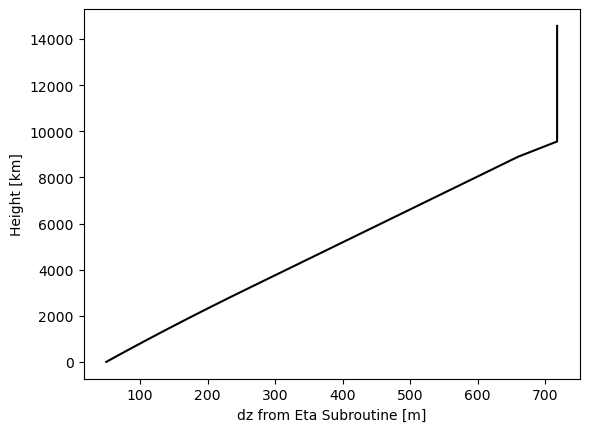

In [10]:
# WRF Stretched vertical levels subroutine

inlev=(75,85,95)
nlev=80           # number of levels
# iptop=(10*1e2,15*1e2,20*1e2)
ptop=12*1e2       # top pressure (Pa)
# idzmax=(480,600,700,800,1000)
dzmax=500         # max dz
dzbot=50          # bottom dz
# idzs=(1.0, 1.02, 1.05, 1.1, 1.2, 1.3)
dzstretch_s = 1.06 # lower stretch factor
idzu=(1.06, 1.07, 1.08, 1.1, 1.2)
dzstretch_u = 1.07 # upper stretch factor

ndims=np.size(idzu)

for idim in range(1):
# for idim in range(ndims):

    # nlev=inlev[idim]
    # dzmax=idzmax[idim]
    # dzstretch_s = idzs[idim]
    # dzstretch_u = idzu[idim]
    # ptop=iptop[idim]

    dz_sav, zup = get_dz(nlev, ptop, dzmax, dzbot, dzstretch_s, dzstretch_u)

    iztrop = np.min(np.where(zup > 15e3))
    if idim == 0:
        line='k'
    elif idim == 1:
        line='g'
    elif idim == 2:
        line='b'
    elif idim == 3:
        line='r'
    elif idim == 4:
        line='m'
    plt.plot(dz_sav[0:iztrop],zup[0:iztrop], line)
    plt.xlabel("dz from Eta Subroutine [m]")
    plt.ylabel("Height [km]")

In [11]:
# # Compute eta
#          CALL levels(kte-1, p_top, znw, max_dz, dzbot, dzstretch_s, dzstretch_u, r_d, g )
#          p_surf = p00
#          tiso_r8    = tiso
#          t00_r8     = t00
#          a_r8       = a
#          p00_r8     = p00
#          mub = p_surf - p_top
#          phb(1) = 0.
#          DO k = 1, kte-1
#             pb = (znw(k)+znw(k+1))*0.5 * (p_surf - p_top) + p_top
#             temp = MAX ( tiso_r8, t00_r8 + A_r8*LOG(pb/p00_r8) )
#             IF ( pb .LT. p_strat ) THEN
#                temp = tiso + A_strat * LOG ( pb/p_strat )
#             END IF
#             t_init = temp*(p00/pb)**(r_d/cp) - t0
#             alb(k) = (r_d/p1000mb)*(t_init+t0)*(pb/p1000mb)**cvpm
#             phb(k+1) = phb(k) - (znw(k+1)-znw(k)) * mub*alb(k)
#          END DO
#        ELSE
#          print *,'auto_levels_opt=',auto_levels_opt
#          CALL wrf_error_fatal ( 'auto_levels_opt needs to be 1 or 2')
#        ENDIF